**Samuel Atilano**

Spring 2025

CS 343: Neural Networks

Project 4: Transfer Learning

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import tf_util
from deep_dream import DeepDream

plt.show()
plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 16})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 3: DeepDream

You will make use of a pre-trained neural network (`VGG19`) to implement the **DeepDream (gradient ascent)** algorithm using TensorFlow to generate art with a neural network! The algorithm projects the receptive fields of specific filters and/or layers onto the input image to create some trippy effects! A neat side effect of this process is that you can visualize how learned weights at different levels of the network interact with parts of the input image.

This task will expose you to TensorFlow's low level API that operates on image data in the Tensor data structure.

### Overview

1. Load in the VGG19 pre-trained network without the output layer.
2. Make a readout model — a `Keras Model` object that allows us extract activations (`netActs`) within the subset of VGG19 network layers of our choice. Neurons in these layers of the VGG19 network will "dream": modify the input image to amplify patterns that the cells "want to see" based on their learned weight patterns. 
3. Select the types of layers (e.g. conv, pooling, etc) that we want to use to run Deep Dream on to influence the input (generated) image.
4. Pass image through the readout network model, compute the netAct values and gradient at the selected layers.
5. Do gradient ascent where we add a proportion of the gradient from a network layer back into the generated image for some number of iterations.

### 3a. Import and plot the image of Miller

`miller3_224x224.jpg` is the initial image that will serve as your **generated image**.

In the cell below:
- Load in the Miller test image `miller3_224x224.jpg` at 224 x 224 resolution. This matches the resolution of images on which VGG19 was trained.
- Normalize the image so that pixel values may span (0, 1) rather than (0, 255). Do this by dividing by 255. You should **not** use min-max normalization here (see note below)!
- Make a plot of the image.

*Why you do not want to use min-max normalization: If you have a dark image that does not have white, min-max normalization will introduce a white value when it was not there originally. This will distort the colors in your image. Dividing by the max possible pixel value (255) works around this issue.*

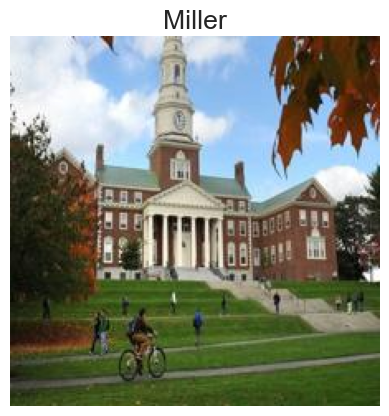

In [3]:
def plot_img(img, title=''):
    plt.imshow(img)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

generated_img = Image.open("images/miller3_224x224.jpg")
generated_img = np.asarray(generated_img)/255

plot_img(generated_img, 'Miller')

In [4]:
# Keep this test code
print(f'Image shape is {generated_img.shape} and should be (224, 224, 3)')
print(f'Image min/max is: {generated_img.min()}/{generated_img.max()}. It should be 0.0/1.0')

Image shape is (224, 224, 3) and should be (224, 224, 3)
Image min/max is: 0.0/1.0. It should be 0.0/1.0


### 3b. Load in pre-trained VGG19 network.

Load in the [pre-trained VGG19 network](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19) and set it to a variable called `pretrained_net`. Make sure the existing weights are not trainable and don't load/include the trained output layer.

If you call the `summary()` method on the network object, you should see the following at the bottom:

    Total params: 20,024,384 (76.39 MB)
    Trainable params: 0 (0.00 B)
    Non-trainable params: 20,024,384 (76.39 MB)

In [5]:
#Creating the network
input_nonbatch_shape = generated_img.shape[0:]
pretrained_net = tf.keras.applications.VGG19(input_shape=input_nonbatch_shape, weights='imagenet', include_top=False)
pretrained_net.trainable = False
pretrained_net.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

### 3c. Write `load_pretrained_net` to automate loading of pretrained network

In `tf_util.py`, adapt your code from the previous subtask to write the `load_pretrained_net` function. This function automates the process of loading the pretrained network and paves the way for possibly loading in pre-trained networks other than VGG19.

Call your function in the cell below. Calling the `summary` method on the returned pretrained network object should produce the same output as in Task 3b.

In [6]:
#Calling on the function
pretrained_net = tf_util.load_pretrained_net()
pretrained_net.summary()


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

### 3d. Create a list of `VGG19` network layer names and those whose activation we want to sample

In `tf_util.py`, implement the following functions:
- `get_all_layer_strs(pretrained_net)`: Extract a list of strings from the pretrained network that represents all the layer names.
- `filter_layer_strs(layer_names, match_str='block5')`: Filter out layer names from the complete list that have a certain substring. For example, return the subset of layers that have `'block5'` in their name. This is the list of **selected layers** whose activity we will amplify by adding their gradient back into the input image (i.e. these layers will "do the dreaming").

Run the following test code below to check your implementations. Each function should be short (~1-5 lines of code).

In [7]:
# Get all layer names
layer_names = tf_util.get_all_layer_strs(pretrained_net)
print(f'Your full list of layers contains {len(layer_names)} names and it should contain 22.')
print(f'Your first layer name is {layer_names[0]} and it should be input_1.')
print(' It is not a problem if you have a different int after the underscore (e.g. input_3)')
print(f'Your last layer name is {layer_names[-1]} and it should be block5_pool.')

print()
selected_layer_names = tf_util.filter_layer_strs(layer_names, match_str='block5')
print(f'Your selected layer names are:\n{selected_layer_names}\nand they should be')
print("['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']")

Your full list of layers contains 22 names and it should contain 22.
Your first layer name is input_layer_1 and it should be input_1.
 It is not a problem if you have a different int after the underscore (e.g. input_3)
Your last layer name is block5_pool and it should be block5_pool.

Your selected layer names are:
['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']
and they should be
['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


### 3e. Preprocess initial generated image

In `tf_util.py`, implement the function `preprocess_image2tf(img, as_var)`. This function takes the initial generated image (e.g. `miller3.jpg`) in Numpy ndarray format and converts it to a TensorFlow Variable tensor.

In the cell below, call your function to preprocess the test image of Miller as a TensorFlow Variable. Name the preprocessed image `generated_img_tf`.

In [8]:
#Preprocessing the image
generated_img_tf = tf_util.preprocess_image2tf(generated_img, True)

In [9]:
# Keep below test code
print(f'The shape of the initial generated image is {generated_img_tf.shape} and should be (1, 224, 224, 3)')
print(f'The min/max of the initial generated image is {tf.reduce_min(generated_img_tf)}/{tf.reduce_max(generated_img_tf)} and should be 0.0/1.0')
print(f"The datatype of the initial generated image is {generated_img_tf.dtype} and should be <dtype: 'float32'>")
print(f'The initial generated image is trainable? {hasattr(generated_img_tf, "trainable")}. It should be!')

The shape of the initial generated image is (1, 224, 224, 3) and should be (1, 224, 224, 3)
The min/max of the initial generated image is 0.0/1.0 and should be 0.0/1.0
The datatype of the initial generated image is <dtype: 'float32'> and should be <dtype: 'float32'>
The initial generated image is trainable? False. It should be!


### 3f. Build VGG19 selected layer readout model

When we do the forward pass with the generated image (e.g. `miller3`), we get activations in every network layer. However, we only want a select group of layers to influence the input image (e.g. only those with `block5` in the name). We could in principle take the list of ALL the netActs and extract the netActs we want according to indices of the desired layers, but there is more overhead with this approach since there are a lot of netAct values we won't use! It is more convenient to build a `tf.keras.Model` object based on the pretrained network that returns a list of netActs *in only the layers we specify*. We will call this model that returns the subset of layer netActs that we care about **the readout model**.

In `tf_util.py`, implement the function `make_readout_model(pretrained_net, layer_names)` that builds the readout model.

In [10]:
test_readout_model = tf_util.make_readout_model(pretrained_net, selected_layer_names)

rng = tf.random.Generator.from_seed(0)
test_input = rng.uniform(shape=(1, 224, 224, 3))
test_net_acts = test_readout_model(test_input)
print(f'Number of layers of netAct returned is {len(test_net_acts)} and should be 5')
print(f'Shape of first layer of netActs is {test_net_acts[0].shape} and should be (1, 14, 14, 512)')
print(f'First few netAct values of first layer filters in top-left corner:\n{test_net_acts[0][0,0,0,:5]}')
print('and they should be:')
print('[0.179 0.    2.947 0.    0.   ]')
print(f'Shape of last layer of netActs is {test_net_acts[-1].shape} and should be (1, 7, 7, 512)')
print(f'First few netAct values of last layer filters in top-left corner:\n{test_net_acts[-1][0,0,0,:5]}')
print('and they should be:')
print('[0.399 0.    0.    0.    0.699]')


Number of layers of netAct returned is 5 and should be 5
Shape of first layer of netActs is (1, 14, 14, 512) and should be (1, 14, 14, 512)
First few netAct values of first layer filters in top-left corner:
[0.179 0.    2.947 0.    0.   ]
and they should be:
[0.179 0.    2.947 0.    0.   ]
Shape of last layer of netActs is (1, 7, 7, 512) and should be (1, 7, 7, 512)
First few netAct values of last layer filters in top-left corner:
[0.399 0.    0.    0.    0.699]
and they should be:
[0.399 0.    0.    0.    0.699]


### 3g. Start implementing Deep Dream network

Implement the following `DeepDream` class methods in `deep_dream.py`:
- Constructor
- `loss_layer(self, layer_net_acts)`: Computes one selected layer's contribution to the total loss. This is the mean activation (`netAct`) across the layer.
- `forward(self, gen_img, eps=1e-8, standardize_grads=True)`: Does the forward pass with the generated image, computes the total loss, and computes the gradient of the loss with respect to the input generated image. If `standardize_grads` is set to `True`, the image gradients should be standardized according to the usual formula (see below).

#### Image gradient standardization

The following equation computes the standardized image gradient $\hat{g}_{i,j}$ at pixel $(i,j)$ in the image gradient.

$$
\hat{g}_{i,j} = \frac{g_{i,j} - \mu_g}{\sigma_g + \epsilon}
$$

where $g_{i,j}$ is the original/raw gradient of the image $(i,j)$ with respect to the total loss (i.e. `d_image`), $\mu_g$ is the mean of the image gradients, $\sigma_g$ is the standard deviation of the image gradients, and $\epsilon$ a small numer (e.g. `1e-8`) to prevent possible division by 0.

Notes:
- Remember that the shape of `d_thing` has the same shape as `thing`. So `d_image` has shape `(224, 224, 3)` — every pixel in the original image gets a gradient update.

#### (i) Test `loss_layer`

In [11]:
test_dd = DeepDream(pretrained_net, selected_layer_names)

In [12]:
rng = tf.random.Generator.from_seed(0)
test_layer_net_acts = rng.uniform(shape=(1, 14, 14, 512))
test_layer_loss = test_dd.loss_layer(test_layer_net_acts)
print(f'Your test layer loss is {test_layer_loss:.5f} and should be 0.49952')

Your test layer loss is 0.49952 and should be 0.49952


#### (ii) Test `forward`

In [13]:
rng = tf.random.Generator.from_seed(0)
test_img_tf = tf.Variable(rng.uniform(shape=(1, 224, 224, 3), minval=0, maxval=1))
test_loss, test_grads = test_dd.forward(test_img_tf)
print(f'Your total loss is {test_loss:.5f} and should be 0.26621')
print(f'The shape of your image gradients are {test_grads.shape} and it should be (1, 224, 224, 3)')
print(f'The first few gradients are\n{test_grads[0,0,:5,0]}\nand they should be\n[-0.102  0.398  0.599  0.388  0.71 ]')

Your total loss is 0.26621 and should be 0.26621
The shape of your image gradients are (1, 224, 224, 3) and it should be (1, 224, 224, 3)
The first few gradients are
[-0.102  0.398  0.599  0.388  0.71 ]
and they should be
[-0.102  0.398  0.599  0.388  0.71 ]


### 3h. Implement `fit`: use gradient ascent algorithm to iteratively modify generated image

The `fit` method uses **gradient ascent** to update the generated image on every epoch — i.e. the network modifies the input image across epochs based on the image gradients. The result is a surreal, trippy, dreamy effect that merges the neural and image representations.

#### Gradient ascent

$$
I(t+1) = I(t) + \alpha \times \hat{g}
$$

where $I$ is the generated image on epoch $t$, $\alpha$ is the learning rate, and $\hat{g}$ is the image gradient on the current epoch.

#### Test: Deep Dream for 1 epoch

The code below runs `fit` for one epoch.
- You should print out the estimated amount of time in minutes to complete `E` epochs.
- You should print out how many epochs have been completed out of `E` total. This should happen on the first epoch (and in general `print_every` epochs).
- `fit` should generate a plot showing the generated image after 1 epoch. *You should see cool shapes starting to emerge in the generated image*! To help make this happen, implement `tf2image(tensor)` in `tf_util.py` that converts the TensorFlow tensor into a PIL `Image` object.
- You should export a JPG of the generated image in the `deep_dream_output` folder within your project working directory (*create it if it doesn't exist*). 

Here is an example progress printout with the estimated time:

```
Epoch 0/0 completed
  1 epoch took 0.010 mins. Expected runtime is 0.010 mins.
```

*Note: the `tf.identity` makes and returns a copy of `generated_img_tf` — this way we do not modify the original Tensor of the image during this test.*


In [14]:
gen_img_1epoch = tf.Variable(tf.identity(generated_img_tf))
loss_hist = test_dd.fit(gen_img_1epoch, n_epochs=1, lr=0.1)
print('Test code:')
print(f'Your loss over 1 epoch is {loss_hist[0]:.1f} and should be 0.4')
print(f'Generated image min/max pixel values are {tf.reduce_min(gen_img_1epoch)}/{tf.reduce_max(gen_img_1epoch)} and should be 0.0/1.0')

Epoch:0/1. Training Loss: 0.35666507482528687
Test code:
Your loss over 1 epoch is 0.4 and should be 0.4
Generated image min/max pixel values are 0.0/1.0 and should be 0.0/1.0


### 3i. Run Deep Dream on `miller3_224x224.jpg`

In the cell below, copy-and-paste code that you've written above to:
- Load in and preprocess the initial generated image (`miller3_224x224.jpg` here).
- Load in the pretrained VGG19 network.
- Creating a `DeepDream` network and fitting it to the image over `26` epochs with the default learning rate of `0.01`.
- Only activations in layers with `block5` in the name should contribute to the loss and lead to modifications of the generated image.

The goal is to run the complete Deep Dream algorithm on a generated image without having to execute all the cells above.

The cell below should show `miller3` after running fit for 26 epochs. *Even if your computer is a few years old, this should take at most 5 minutes.*

In [15]:
#Loading in img and preprocess
generated_img = Image.open("images/miller3_224x224.jpg")
generated_img = np.asarray(generated_img)/255

img_tf = tf_util.preprocess_image2tf(generated_img, True)
img_tf_var = tf.Variable(tf.identity(img_tf))

#Loading in the pretrained network
pretrained_net = tf_util.load_pretrained_net()

#Creating the DeepDream network
deep = DeepDream(pretrained_net, selected_layer_names)

#Fitting
deep.fit(img_tf_var, 26, 0.01)

Epoch:0/26. Training Loss: 0.35666507482528687
Epoch:25/26. Training Loss: 1.21692955493927


[<tf.Tensor: shape=(), dtype=float32, numpy=0.35666507482528687>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.42613038420677185>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.48694029450416565>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5432378053665161>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.594668984413147>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.640887975692749>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6869217157363892>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7301443815231323>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7712178826332092>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8093155026435852>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8441689610481262>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8771327137947083>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9082395434379578>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9381729364395142>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9674213528633118>,
 <tf.Tensor: shape=(), d

### 3j. Refine Deep Dream by running it with multiple image scales

While the existing Deep Dream algorithm results in some cool effects, a little additional work can make the Deep Dream images look even better.

Implement `fit_multiscale` in `deep_dream.py`. In this version you call `fit` to run the gradient ascent algorithm on the generated image over multiple runs. Each time you finish a run, scale (resize) the image so that you run gradient ascent again on the larger version of image.

Since this is effectively repeating `gradient_ascent` a set number of times (`n_scales`), it will take longer to finish computing.

#### Test `fit_multiscale`

Copy-and-paste your code above from Task 3i, but now run `fit_multiscale` instead of `fit`. Run it with default parameters for now. The cell below should:
- show the generated image (`miller3`) after gradient ascent is run on the generated image at each scale. 
- print outs showing the progress (i.e. number of scales currently completed).
- Estimated total runtime based on the first scale.

*Even if your computer is several years old, this should take at most 5-10 mins to finish. If it is taking too long and you think that your code is working properly, run it in Davis 102 or cut down on the number of epochs and scales.*

In [16]:
#Loading in img and preprocess
generated_img = Image.open("images/miller3_224x224.jpg")
generated_img = np.asarray(generated_img)/255

img_tf = tf_util.preprocess_image2tf(generated_img, True)
img_tf_var = tf.Variable(tf.identity(img_tf))

#Loading in the pretrained network
pretrained_net = tf_util.load_pretrained_net()

#Creating the DeepDream network
deep = DeepDream(pretrained_net, selected_layer_names)

#Fitting
deep.fit_multiscale(img_tf_var, n_epochs=26, lr=0.01)

Epoch:0/26. Training Loss: 0.35666507482528687
Epoch:25/26. Training Loss: 1.21692955493927
Scale:0/4.
Epoch:0/26. Training Loss: 0.8024457097053528
Epoch:25/26. Training Loss: 1.4013619422912598
Scale:1/4.
Epoch:0/26. Training Loss: 0.8621627688407898
Epoch:25/26. Training Loss: 1.4264864921569824
Scale:2/4.
Epoch:0/26. Training Loss: 0.8748909831047058
Epoch:25/26. Training Loss: 1.4381557703018188
Scale:3/4.


[<tf.Tensor: shape=(), dtype=float32, numpy=0.35666507482528687>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.42613038420677185>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.48694029450416565>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5432378053665161>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.594668984413147>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.640887975692749>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6869217157363892>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7301443815231323>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7712178826332092>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8093155026435852>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8441689610481262>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8771327137947083>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9082395434379578>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9381729364395142>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9674213528633118>,
 <tf.Tensor: shape=(), d

### 3k. Run Deep Dream on at least one other image

Copy-and-paste your code again and run either the single-scale or multi-scale version of Deep Dream on another image of your choice. It could be one of the other provided images. Adjust hyperparameters as necessary so that the generated image bears some resemblance to the original image (i.e. the generated image is not totally dominated by the network influence).

**Note about the size of your image:**
- You can resize your image to 224x224, the resolution of images VGG19 was trained on.
- If you have a more powerful machine (or are willing to wait longer for prettier pictures), you can use higher resolution images. But you should start with the 224 x 224 version for debugging purposes. You can use the PIL Image resize method. Alternatively, there are numerous external tools (e.g. ImageMagick) and other Python-based ways to accomplish this.

In [18]:
#Loading in img and preprocess
generated_img = Image.open("images/starry_night_224x224.jpg")
generated_img = np.asarray(generated_img)/255

img_tf = tf_util.preprocess_image2tf(generated_img, True)
img_tf_var = tf.Variable(tf.identity(img_tf))

#Loading in the pretrained network
pretrained_net = tf_util.load_pretrained_net()

#Creating the DeepDream network
deep = DeepDream(pretrained_net, selected_layer_names)

#Fitting
deep.fit_multiscale(img_tf_var, n_epochs=26, lr=0.01)

Epoch:0/26. Training Loss: 0.4146362841129303
Epoch:25/26. Training Loss: 1.2672955989837646
Scale:0/4.
Epoch:0/26. Training Loss: 0.8648431897163391
Epoch:25/26. Training Loss: 1.4376906156539917
Scale:1/4.
Epoch:0/26. Training Loss: 0.9110944867134094
Epoch:25/26. Training Loss: 1.46602463722229
Scale:2/4.
Epoch:0/26. Training Loss: 0.9024195671081543
Epoch:25/26. Training Loss: 1.4416606426239014
Scale:3/4.


[<tf.Tensor: shape=(), dtype=float32, numpy=0.4146362841129303>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.49200278520584106>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.557556688785553>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6179075837135315>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6729906797409058>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7223559617996216>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.7680053114891052>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8092495799064636>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8483036160469055>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8852425813674927>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9198368787765503>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9529069066047668>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9817512631416321>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0101282596588135>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.036793828010559>,
 <tf.Tensor: shape=(), dty

### 3l. Questions

Generate one or more Deep Dream images to accompany each of your written answers to the following questions. You can include them inline with your answers below.

**Question 6:** Why does the multi-scale version tends to produce better visualizations? *Hint: think about the filter receptive fields involved in the process.*

**Question 7**: What is one key difference in the generated images when only the earlier/later network layers are involved in the Deep Dream process? **Make 1 or more images that illustrate your point.**

**Question 8**: What is one key difference in the generated images when you let pooling vs different conv layers contribute to the generated image.  **Make 1 or more images that illustrate your point.**

**Answer 6:** 

Multi-scale produces better visualizations because by scaling the images, the filters looking at both smaller features and eventually larger features to match when calculating the net_acts after each scale loop

**Answer 7**: 

Earlier layers look at small features, such as edges and textures. In comparison, when only using the layer features the image would be generated with more complex features such as eyes or faces. 

**Answer 8**: 

Because each Convolutional layer contains specific spatial details to that specific layer, using different layers to generate an image will result in a different style. Such as one layer specializing in edges will make a different image versus another layer that specializes in color
using pooling will summarize these features, and not make them as profound in the iamge

## Extensions

### General guidelines

1. Never integrate extensions into your base project so that they change the expected behavior of core functions. If your extension changes the core design/behavior, no problem, duplicate your working base project and add features from there.
2. Check the rubric to keep in mind how extensions on this project will be graded.
3. While I may consult your code and "written log" of what you did, **I am grading your extensions based on what you present in your 3-5 min video.**
3. I suggest documenting your explorations in a "log" or "lab notebook" style (i.e. documenting your thought/progression/discovery/learning process). I'm not grading your writing, so you can keep it succinct. **Whatever is most useful to you to remember what you did.** 
4. I suggest taking a hypothesis driven approach. For example "I was curious about X so I explored Y. I found Z, which was not what I expected because..., so then tried A..."
5. Make plots to help showcase your results.
6. **More is not necessarily better.** Generally, a small number of "in-depth" extensions count for more than many "shallow" extensions.

### AI guidelines

You may use AI in mostly any capacity for extensions. However, keep in mind:
1. There is no need to use AI at all!
2. You are welcome to use AI as a tool (e.g. automate something that is tedious, help you get unstuck, etc.). However, you should be coding, you should be thinking, you should be writing, you should be creating. If you are spending most (or even close to most) of your time typing into a chatbot and copy-pasting, you have probably gone too far with AI use.
3. I don't find large volumes of AI generated code/text/plots to be particularly impressive and you risk losing my interest while grading. Remember: I'm grading your extensions based on your video presentation. **More is not necessarily better.**

### Video guidelines

1. Please try to keep your video to 5 minutes (*I have other projects to grade!*). If you turn in a longer video, I make no promise that I will watch more than 5 minutes.
2. Your screen should be shared as you show me what you did. A live video of your face should also appear somewhere on the screen (e.g. picture-in-picture overlay / split screen).
3. Your partner should join you for the video and take turns talking, but, if necessary, it is fine to have one team member present during the record the video.
4. Do not simply read text from your notebook, do not read from a prepared script. I am not grading how polished your video presentation is (see extension grading criteria on rubric). 
5. I am looking for original and creative explorations sparked by your curiosity/interest/passion in a topic. This should be apparent in your video.
6. Be natural,, don't feel the need to impress me with fancy language. If it is helpful, imagine that we are talking one-on-one about your extension. Tell me what you did :)

### Extension ideas

### 1. Run DeepDream on your own images. Make some interesting effects.

Change hyperparameters as needed to get cool results.

### 2. Research other pretrained networks in TensorFlow and run DeepDream on their layers/filters.

### 3. Visualize individual CNN filters

- Rather than having the netActs from each entire layer influence the generated image, only have the netAct values of specific filters influence the generated image. This feature is is potentially interesting/useful for analysis because you can visualize what shape/object/animal/texture a particular filter learns (e.g. filter at index 0 learns seals, filter at index 1 learns birds, filter at index 2 learns fish, etc). This would involve defining a list of indices to sample within all or specific layers.
- You can use this approach to visualize the features that a CNN filter learns at any depth of the network. Instead of presenting the network with an actual image, apply Deep Dream to an image of RGB noise. The selected filter will amplify patterns/textures that are consistent with those to which it is tuned.

### 4. Transfer learning: What's the best test accuracy that you can achieve on the hot dog or not dataset? How did you do it?

### 5. Keras ConvNet4: Explore and analyze how different network architectures affect the STL-10 results.

### 6. Transfer learning: Can you apply Transfer learning to a binary or multi-class classification task with another dataset of your choice?